In [1]:
import numpy as np
from skimage.measure import block_reduce
from datetime import datetime
import gc
import sys
import os
import sys
import os
from pathlib import Path
sys.path.append(Path(os.getcwd()).parent.__str__())
from src.utils import *
plt.style.use('classic')
set_gpytorch_settings(False)

In [2]:
# Reading data file and cleaning missing values
df = pd.read_feather(
    '../Data/feather/46221_9999_wave_height.feather')
parameters_wave = ['time', 'wave_height']
parameters_temp = ['time', 'sea_surface_temperature']
df_as_np = df \
    .loc[:, parameters_wave] \
    .astype(float) \
    .replace(
        to_replace=[999.0, 99.0, 9999.0],
        value=np.nan) \
    .to_numpy()
using_sk = block_reduce(
    df_as_np, block_size=(24, 1),
    func=np.mean).astype(float)

# Convert to torch tensors
X = torch \
    .tensor(using_sk[:-1, 0]) \
    .float() \
    .cuda()
y = torch \
    .tensor(using_sk[:-1, 1]) \
    .float() \
    .cuda()
X = X.reshape(-1, 1)
y = y.reshape(-1, 1)

X = X[~torch.any(y.isnan(), dim=1)]
y = y[~torch.any(y.isnan(), dim=1)]
y = y.flatten()
X_old = X


# Helper functions
def scaler(
        a,
        X_old=X_old,
        center=True):
    if center is True:
        a = a - X_old.min(0).values
    return a / (X_old.max(0).values - X_old.min(0).values)


def add_new_kernel_term(
        original_kernel, new_kernel_term, operation):
    return str(original_kernel) + str(operation) + str(new_kernel_term)


# GP Model Declaration
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(
            self,
            train_x_, train_y_,
            likelihood, kernel):
        super(ExactGPModel, self).__init__(train_x_, train_y_, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(
            self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions \
            .MultivariateNormal(mean_x, covar_x)


# Scale the time axis and log transform the Y-values
X = scaler(X, X_old)
y = y.log()

# max, min, and scale factor declaration
scaler_max = X_old.max(0).values.item()
scaler_min = X_old.min(0).values.item()
scale_factor = scaler_max - scaler_min
scaler_consts = [scaler_max, scaler_min, scale_factor]

# Plot the block reduced data set
temp_for_plotting = pd.Series(
    using_sk[:-1, 0] * 1e9, dtype='datetime64[ns]')
# plt.plot(temp_for_plotting, using_sk[:-1, 1])
# plt.xlabel("Time (epoch)")
# plt.ylabel("Significant Wave Height (meters)")
# plt.title(f'Significant wave height - after block reducing')
# plt.show()

print(
    f'Scale Max: {scaler_max}\n '
    f'Scale Min: {scaler_min}\n '
    f'Scale Factor: {scale_factor}\n '
    f'Before Block Reduce: {df_as_np.shape}\n'
    f'After Block Reduce: {using_sk.shape}\n'
    f'Number of Nans: {np.count_nonzero(np.isnan(df_as_np))}\n'
    f'Start Time: {datetime.fromtimestamp(df_as_np[0, 0])}\n'
    f'End Time: {datetime.fromtimestamp(df_as_np[-1, 0])}\n'
    f'Number of Days: {df_as_np.shape[0] / 48}\n'
    f'Time Period (Days): {(df_as_np[-1, 0] - df_as_np[0, 0]) / 24 / 60 / 60}\n ')

# Prediction range, training and test set define (14, 3, 365)
predict_days_out = 3
test_n = 2 * predict_days_out

# Split the data into train and test sets
# *contiguous means they are sitting next to each other in memory*
train_x = X[test_n:].contiguous().cuda()
train_y = y[test_n:].contiguous().cuda()
test_x = X[-test_n:].contiguous().cuda()
test_y = y[-test_n:].contiguous().cuda()

# Create a list of random starting indices for the subtest sets
n_total = train_x.shape[0]
np.random.seed(2023)
torch.manual_seed(2023)
idx_list = np.random.randint(
    low=n_total / 2,
    high=n_total - test_n,
    size=100)
    # size=10)

Scale Max: 1677108352.0
 Scale Min: 1349069952.0
 Scale Factor: 328038400.0
 Before Block Reduce: (174818, 2)
After Block Reduce: (7285, 2)
Number of Nans: 0
Start Time: 2012-09-30 16:55:44
End Time: 2023-02-22 23:25:52
Number of Days: 3642.0416666666665
Time Period (Days): 3797.312592592593
 


In [3]:
likelihood = gpytorch.likelihoods.GaussianLikelihood().cuda()
model = ExactGPModel(
    train_x, train_y, likelihood, 
    kernel=\
        ScaleKernel(RQKernel(
            alpha_constraint=GreaterThan(0.000329),
            lengthscale_constraint=GreaterThan(0.000329)))
        # +ScaleKernel(RBFKernel())
        +ScaleKernel(PeriodicKernel(
            period_length_constraint=Interval(
                lower_bound=1e-4, 
                upper_bound=0.8, 
                initial_value=scaler(60*60*24*365, center=False)),
            lengthscale_constraint=GreaterThan(0.000329)))
        +ScaleKernel(AR2Kernel(
            period_constraint=Interval(
                lower_bound=1e-4, 
                upper_bound=0.006),
            lengthscale_constraint=GreaterThan(0.000329)))
        +ScaleKernel(MaternKernel(
            nu=2.5, 
            lengthscale_constraint=GreaterThan(0.000435)))
    ).cuda()

model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-8, betas=(0.9, 0.999), eps=1e-10)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.4, patience=4, verbose=False, eps=1e-9)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
num_iter_trys = tqdm.tqdm(
    range(1000), 
    desc=f'Training exactGP: {1000} iterations')
for i in num_iter_trys:
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    scheduler.step(loss)

Training exactGP: 1000 iterations: 100%|██████████| 1000/1000 [05:46<00:00,  2.89it/s]


In [4]:
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    model.set_train_data(train_x[:-6, 0], train_y[:-6], strict=False)
    test_y_hat = likelihood(model(test_x))
    trained_predictive_mean = test_y_hat.mean
    lower, upper = test_y_hat.confidence_region()

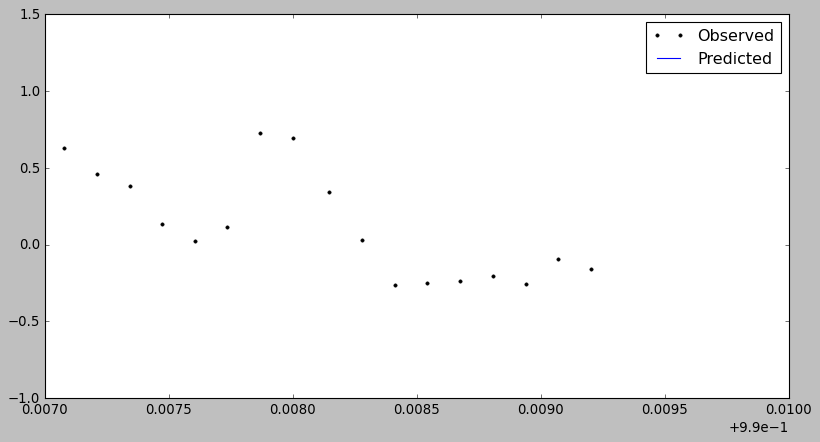

In [8]:
# Plot the results  
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(
    train_x[:-6, 0].detach().cpu().numpy(),
    train_y[:-6].detach().cpu().numpy(),
    'k.',
    label='Observed')
ax.plot(
    test_x[:, 0].detach().cpu().numpy(),
    trained_predictive_mean.detach().cpu().numpy(),
    'b',
    label='Predicted')
# ax.fill_between(
#     test_x[:, 0].cpu.numpy(),
#     lower.cpu().numpy(),
#     upper.cpu().numpy(),
#     alpha=0.5)
ax.set_xlim([.997, 1])
ax.legend()

In [7]:
# trained_predictive_mean
test_y_hat.mean
# test_x[:, 0].detach().cpu().numpy()
# train_x[:, 0].detach().cpu().numpy()

tensor([nan, nan, nan, nan, nan, nan])